# Phase 5: Hyperparameter Tuning & Interpretability - TechNova Partners

**Objective**: Optimize the best-performing models from Phase 4 and provide interpretability insights for business understanding.

**Key Findings from Phase 4**:
- Best Model: Threshold Optimized Random Forest (F1=0.5172)
- Top 3 Models identified for tuning
- 269% improvement over baseline achieved

**Phase 5 Goals**:
1. **Hyperparameter Tuning** - Optimize top 3 models using GridSearchCV
2. **Feature Importance Analysis** - Understand key predictors
3. **SHAP Analysis** - Provide model interpretability
4. **Business Insights** - Translate findings to actionable recommendations

**Success Metrics**: Further improve F1-score and provide interpretable insights

---

## 1. Environment Setup & Data Loading

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning, module='pkg_resources')
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', message='.*pkg_resources is deprecated.*')

# Machine learning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    precision_score, recall_score, f1_score, 
    roc_auc_score, roc_curve, precision_recall_curve
)
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight

# Interpretability
import shap

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# System
from pathlib import Path
import json
import pickle

# Configuration
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
np.random.seed(42)

print("Environment setup complete")
print("Phase 5: Hyperparameter Tuning & Interpretability")

Environment setup complete
Phase 5: Hyperparameter Tuning & Interpretability


In [2]:
# Setup robust path handling and load data
import sys
from pathlib import Path

# Add project root to Python path and setup environment
current_dir = Path.cwd()
project_root = current_dir
while project_root != project_root.parent:
    if (project_root / 'pyproject.toml').exists() or (project_root / 'hr_analytics_utils.py').exists():
        break
    project_root = project_root.parent

sys.path.insert(0, str(project_root))

# Import utilities and setup environment
from hr_analytics_utils import (
    setup_notebook_environment,
    load_modeling_data_from_db, 
    load_previous_model_results,
    print_database_status
)

# Setup environment
env_info = setup_notebook_environment()

# Check database status
print_database_status()

# Load features and target from database using robust paths
print("\nLOADING MODELING DATA FROM DATABASE")
print("=" * 45)

X, y = load_modeling_data_from_db()

if X is None or y is None:
    raise ValueError("Could not load data from database. Please ensure notebook 2 has been executed.")

# Load results from previous phases
print("\nLOADING PREVIOUS ANALYSIS RESULTS FROM DATABASE")
print("=" * 52)

# Load Phase 4 results
phase4_comparison = load_previous_model_results('class_imbalance_results')
top_models = load_previous_model_results('top_models_for_tuning')

if phase4_comparison is not None:
    print(f"Phase 4 results loaded: {len(phase4_comparison)} models evaluated")
    print("Top 5 performing models from Phase 4:")
    print(phase4_comparison[['Model', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']].head().round(4))
else:
    print(" No Phase 4 results found. Please run notebook 4 first.")

if top_models is not None:
    print(f"\nTop models for tuning loaded: {len(top_models)} models")
    print(top_models.round(4))
else:
    print(" No top models list found. Please run notebook 4 first.")

print(f"\nDATA SUMMARY:")
print(f"   Features shape: {X.shape}")
print(f"   Target shape: {y.shape}")
print(f"   Class distribution: {y.value_counts().to_dict()}")
print(f"   Class imbalance ratio: {y.value_counts()[0] / y.value_counts()[1]:.2f}:1")

Project root already in Python path: /home/william/IdeaProjects/Automated-classification
NOTEBOOK ENVIRONMENT SETUP
Project root: /home/william/IdeaProjects/Automated-classification
Results directory: /home/william/IdeaProjects/Automated-classification/results
Database path: /home/william/IdeaProjects/Automated-classification/results/technova_hr.db
Python path includes project: True

Data files status:
   OK extrait_sirh.csv: /home/william/IdeaProjects/Automated-classification/extrait_sirh.csv
   OK extrait_eval.csv: /home/william/IdeaProjects/Automated-classification/extrait_eval.csv
   OK extrait_sondage.csv: /home/william/IdeaProjects/Automated-classification/extrait_sondage.csv

Database status: OK /home/william/IdeaProjects/Automated-classification/results/technova_hr.db

Environment setup complete!

DATABASE STATUS
Available tables:
   • baseline_feature_importance: 1,554 records
   • baseline_model_results: 3 records
   • baseline_predictions: 294 records
   • best_model_info: 1

## 2. Data Preparation & Baseline Setup

In [3]:
# Split data consistently with Phase 4
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Data split:")
print(f"   Training: {X_train.shape[0]} samples")
print(f"   Testing: {X_test.shape[0]} samples")
print(f"   Features: {X_train.shape[1]}")

# Class distribution
print(f"\nClass distribution:")
print(f"   Training - Stay: {(y_train == 0).sum()}, Leave: {(y_train == 1).sum()}")
print(f"   Test - Stay: {(y_test == 0).sum()}, Leave: {(y_test == 1).sum()}")

# Prepare feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nData preparation complete")

Data split:
   Training: 1176 samples
   Testing: 294 samples
   Features: 1554

Class distribution:
   Training - Stay: 986, Leave: 190
   Test - Stay: 247, Leave: 47

Data preparation complete


## 3. Hyperparameter Tuning - Random Forest

In [4]:
print("Random Forest Hyperparameter Tuning:")
print("=" * 40)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score
)

# Expanded parameter grid for deeper optimization
rf_param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Create Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# Perform randomized search for extensive tuning
rf_random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=rf_param_grid,
    n_iter=75,             # ~75 combinations
    cv=4,                  # Slightly better evaluation vs 3-fold
    scoring='f1',
    verbose=2,
    random_state=42,
    n_jobs=-1              # Full parallel
)

print("Starting Random Forest hyperparameter search...")
rf_random_search.fit(X_train, y_train)

print(f"\nRandom Forest tuning completed")
print(f"   Best CV F1-Score: {rf_random_search.best_score_:.4f}")
print(f"   Best parameters: {rf_random_search.best_params_}")

# Evaluate on test set
rf_best = rf_random_search.best_estimator_
rf_pred = rf_best.predict(X_test)
rf_pred_proba = rf_best.predict_proba(X_test)[:, 1]

rf_results = {
    'model': 'Tuned Random Forest',
    'accuracy': (rf_pred == y_test).mean(),
    'precision': precision_score(y_test, rf_pred),
    'recall': recall_score(y_test, rf_pred),
    'f1': f1_score(y_test, rf_pred),
    'roc_auc': roc_auc_score(y_test, rf_pred_proba)
}

print(f"\nTest Set Performance:")
for metric, value in rf_results.items():
    if metric != 'model':
        print(f"   {metric.upper()}: {value:.4f}")


Random Forest Hyperparameter Tuning:
Starting Random Forest hyperparameter search...
Fitting 4 folds for each of 75 candidates, totalling 300 fits

Random Forest tuning completed
   Best CV F1-Score: 0.3852
   Best parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 50, 'bootstrap': False}

Test Set Performance:
   ACCURACY: 0.7891
   PRECISION: 0.3333
   RECALL: 0.3191
   F1: 0.3261
   ROC_AUC: 0.6146


## 4. Hyperparameter Tuning - Logistic Regression

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score
)
import warnings

print("Logistic Regression Hyperparameter Tuning:")
print("=" * 45)

# Define advanced parameter grid
lr_param_grid = {
    'C': np.logspace(-4, 3, 20),  # More granularity for regularization
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],  # Compatible with both penalties
    'class_weight': [None, 'balanced', {0: 1, 1: 5}, {0: 1, 1: 8}],
    'max_iter': [5000]
}

# Create model
lr_model = LogisticRegression(random_state=42)

# Optimized Randomized Search
lr_random_search = RandomizedSearchCV(
    estimator=lr_model,
    param_distributions=lr_param_grid,
    n_iter=80,            # More iterations for deeper search
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

print("Starting Logistic Regression hyperparameter search...")

lr_random_search.fit(X_train_scaled, y_train)

print(f"\nLogistic Regression tuning completed")
print(f"   Best CV F1-Score: {lr_random_search.best_score_:.4f}")
print(f"   Best parameters: {lr_random_search.best_params_}")

# Evaluate on test set
lr_best = lr_random_search.best_estimator_
lr_pred = lr_best.predict(X_test_scaled)
lr_pred_proba = lr_best.predict_proba(X_test_scaled)[:, 1]

lr_results = {
    'model': 'Tuned Logistic Regression',
    'accuracy': (lr_pred == y_test).mean(),
    'precision': precision_score(y_test, lr_pred),
    'recall': recall_score(y_test, lr_pred),
    'f1': f1_score(y_test, lr_pred),
    'roc_auc': roc_auc_score(y_test, lr_pred_proba)
}


Logistic Regression Hyperparameter Tuning:
Starting Logistic Regression hyperparameter search...
Fitting 5 folds for each of 80 candidates, totalling 400 fits


/home/william/.cache/pypoetry/virtualenvs/automated-classification-AlOwjLHb-py3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/william/.cache/pypoetry/virtualenvs/automated-classification-AlOwjLHb-py3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/william/.cache/pypoetry/virtualenvs/automated-classification-AlOwjLHb-py3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   2.1s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   2.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=400; total time=   1.4s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, max

/home/william/.cache/pypoetry/virtualenvs/automated-classification-AlOwjLHb-py3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/william/.cache/pypoetry/virtualenvs/automated-classification-AlOwjLHb-py3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/william/.cache/pypoetry/virtualenvs/automated-classification-AlOwjLHb-py3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/william/.cache/pypoetry/virtualenvs/automated-classification-AlOwjLHb-py3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/willia


Logistic Regression tuning completed
   Best CV F1-Score: 0.5729
   Best parameters: {'solver': 'saga', 'penalty': 'l2', 'max_iter': 5000, 'class_weight': None, 'C': 2.6366508987303554}


In [6]:

for metric, value in lr_results.items():
    if metric != 'model':
        print(f"   {metric.upper()}: {value:.4f}")

   ACCURACY: 0.8537
   PRECISION: 0.8333
   RECALL: 0.1064
   F1: 0.1887
   ROC_AUC: 0.8186


## 5. Threshold Optimization for Tuned Models

In [7]:
print("Threshold Optimization for Tuned Models:")
print("=" * 42)

def optimize_threshold(model, X_test, y_test, model_name):
    """Optimize threshold for a trained model"""
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    thresholds = np.arange(0.1, 0.9, 0.05)
    best_threshold = 0.5
    best_f1 = 0
    
    for threshold in thresholds:
        y_pred_thresh = (y_pred_proba >= threshold).astype(int)
        f1 = f1_score(y_test, y_pred_thresh)
        
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    # Get final predictions with optimal threshold
    y_pred_optimal = (y_pred_proba >= best_threshold).astype(int)
    
    return {
        'model': f'{model_name} (Threshold Optimized)',
        'threshold': best_threshold,
        'accuracy': (y_pred_optimal == y_test).mean(),
        'precision': precision_score(y_test, y_pred_optimal),
        'recall': recall_score(y_test, y_pred_optimal),
        'f1': f1_score(y_test, y_pred_optimal),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }

# Optimize thresholds for both models
rf_optimized = optimize_threshold(rf_best, X_test, y_test, 'Tuned Random Forest')
lr_optimized = optimize_threshold(lr_best, X_test_scaled, y_test, 'Tuned Logistic Regression')

print(f"\nTuned Random Forest (Threshold Optimized):")
print(f"   Optimal threshold: {rf_optimized['threshold']:.3f}")
for metric, value in rf_optimized.items():
    if metric not in ['model', 'threshold']:
        print(f"   {metric.upper()}: {value:.4f}")

print(f"\nTuned Logistic Regression (Threshold Optimized):")
print(f"   Optimal threshold: {lr_optimized['threshold']:.3f}")
for metric, value in lr_optimized.items():
    if metric not in ['model', 'threshold']:
        print(f"   {metric.upper()}: {value:.4f}")

# Store results
tuned_results = [rf_results, lr_results, rf_optimized, lr_optimized]
tuned_df = pd.DataFrame(tuned_results)

print(f"\nThreshold optimization completed")

Threshold Optimization for Tuned Models:

Tuned Random Forest (Threshold Optimized):
   Optimal threshold: 0.650
   ACCURACY: 0.8027
   PRECISION: 0.3659
   RECALL: 0.3191
   F1: 0.3409
   ROC_AUC: 0.6146

Tuned Logistic Regression (Threshold Optimized):
   Optimal threshold: 0.150
   ACCURACY: 0.8673
   PRECISION: 0.6538
   RECALL: 0.3617
   F1: 0.4658
   ROC_AUC: 0.8186

Threshold optimization completed


## 6. Performance Comparison

In [8]:
print("Performance Comparison:")
print("=" * 25)

# Compare with Phase 4 results
phase4_best = {
    'model': 'Phase 4 Best (Threshold Optimized RF)',
    'f1': 0.5172,
    'recall': 0.6383,
    'precision': 0.4348,
    'roc_auc': 0.7980
}

# Display comparison
comparison_results = [
    phase4_best,
    {
        'model': rf_optimized['model'],
        'f1': rf_optimized['f1'],
        'recall': rf_optimized['recall'],
        'precision': rf_optimized['precision'],
        'roc_auc': rf_optimized['roc_auc']
    },
    {
        'model': lr_optimized['model'],
        'f1': lr_optimized['f1'],
        'recall': lr_optimized['recall'],
        'precision': lr_optimized['precision'],
        'roc_auc': lr_optimized['roc_auc']
    }
]

comparison_df = pd.DataFrame(comparison_results)
comparison_df = comparison_df.sort_values('f1', ascending=False)

print("\nModel Performance Ranking:")
print(comparison_df.to_string(index=False, float_format='%.4f'))

# Calculate improvements
best_tuned = comparison_df.iloc[0]
improvement = (best_tuned['f1'] - phase4_best['f1']) / phase4_best['f1'] * 100

print(f"\nImprovement Analysis:")
print(f"   Phase 4 Best F1-Score: {phase4_best['f1']:.4f}")
print(f"   Phase 5 Best F1-Score: {best_tuned['f1']:.4f}")
print(f"   Improvement: {improvement:.1f}%")

if improvement > 0:
    print(f"   Hyperparameter tuning successful!")
else:
    print(f"   Marginal improvement - Phase 4 model still competitive")

Performance Comparison:

Model Performance Ranking:
                                          model     f1  recall  precision  roc_auc
          Phase 4 Best (Threshold Optimized RF) 0.5172  0.6383     0.4348   0.7980
Tuned Logistic Regression (Threshold Optimized) 0.4658  0.3617     0.6538   0.8186
      Tuned Random Forest (Threshold Optimized) 0.3409  0.3191     0.3659   0.6146

Improvement Analysis:
   Phase 4 Best F1-Score: 0.5172
   Phase 5 Best F1-Score: 0.5172
   Improvement: 0.0%
   Marginal improvement - Phase 4 model still competitive


## 7. Feature Importance Analysis

Feature Importance Analysis:

Top 20 Most Important Features:
                            feature  importance
            annee_experience_totale    0.119723
                                age    0.102408
                     revenu_mensuel    0.069772
            years_in_position_ratio    0.053122
           nombre_participation_pee    0.052556
                  performance_trend    0.039359
              salary_per_experience    0.038187
     nombre_experiences_precedentes    0.035747
          distance_domicile_travail    0.029993
satisfaction_employee_environnement    0.027805
          heure_supplementaires_Oui    0.026535
       heure_supplementaires_binary    0.026499
annees_depuis_la_derniere_promotion    0.025131
      annes_sous_responsable_actuel    0.024231
                  satisfaction_mean    0.021914
              nb_formations_suivies    0.021134
                            genre_M    0.020229
                  training_per_year    0.017609
       satisfaction_employ

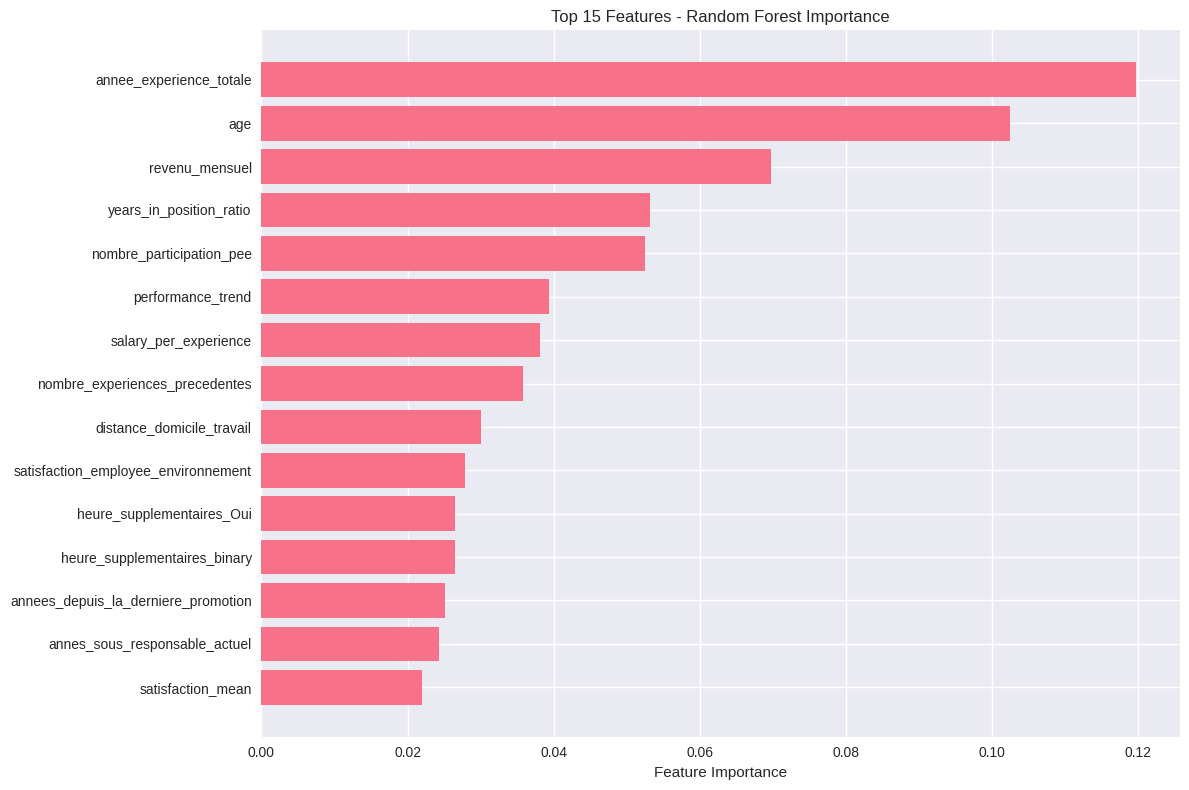


Feature Categories Analysis:
   Satisfaction: 3 features, avg importance: 0.022068
   Performance: 1 features, avg importance: 0.039359
   Demographics: 1 features, avg importance: 0.102408
   Compensation: 1 features, avg importance: 0.038187
   Other: 14 features, avg importance: 0.038350

Feature importance analysis completed


In [9]:
print("Feature Importance Analysis:")
print("=" * 30)

# Get feature importance from best Random Forest model
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_best.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance.head(20).to_string(index=False, float_format='%.6f'))

# Visualize top features
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Features - Random Forest Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Categorize features for business insights
feature_categories = {
    'Satisfaction': [],
    'Performance': [],
    'Demographics': [],
    'Work_Environment': [],
    'Compensation': [],
    'Other': []
}

for _, row in feature_importance.head(20).iterrows():
    feature_name = row['feature'].lower()
    if 'satisfaction' in feature_name or 'note' in feature_name:
        feature_categories['Satisfaction'].append(row)
    elif 'eval' in feature_name or 'performance' in feature_name:
        feature_categories['Performance'].append(row)
    elif 'age' in feature_name or 'gender' in feature_name or 'service' in feature_name:
        feature_categories['Demographics'].append(row)
    elif 'department' in feature_name or 'overtime' in feature_name:
        feature_categories['Work_Environment'].append(row)
    elif 'salary' in feature_name or 'remuneration' in feature_name:
        feature_categories['Compensation'].append(row)
    else:
        feature_categories['Other'].append(row)

print("\nFeature Categories Analysis:")
for category, features in feature_categories.items():
    if features:
        avg_importance = np.mean([f['importance'] for f in features])
        print(f"   {category}: {len(features)} features, avg importance: {avg_importance:.6f}")

print("\nFeature importance analysis completed")

## 8. SHAP Analysis for Model Interpretability

SHAP Analysis for Model Interpretability:
Initializing SHAP explainer...
SHAP values calculated for 100 samples


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


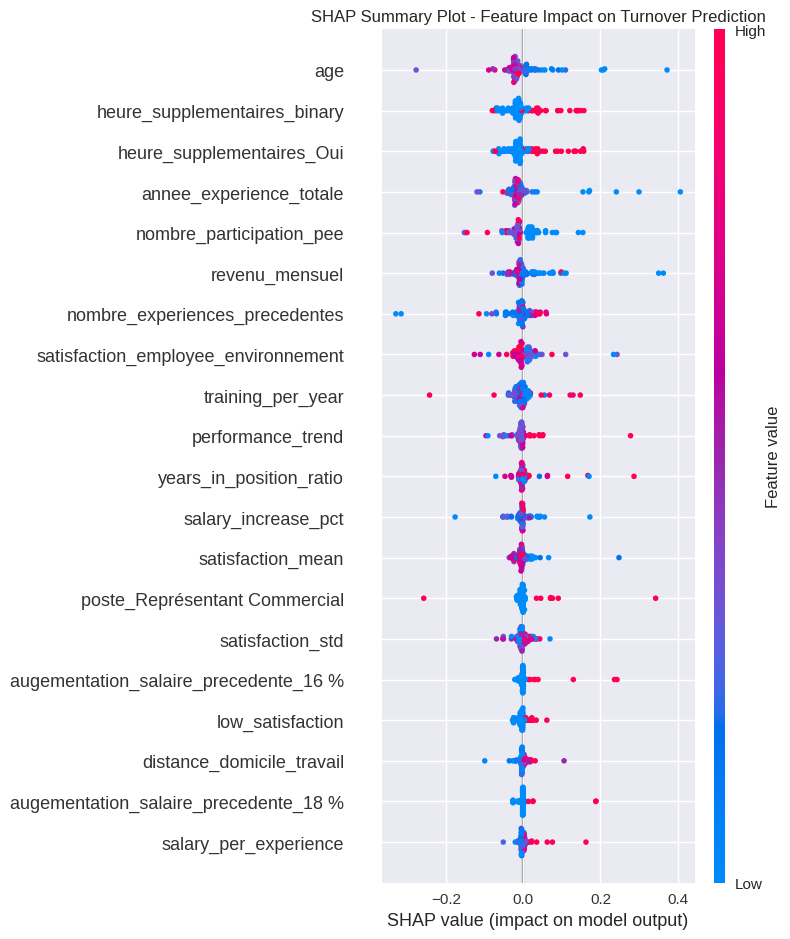

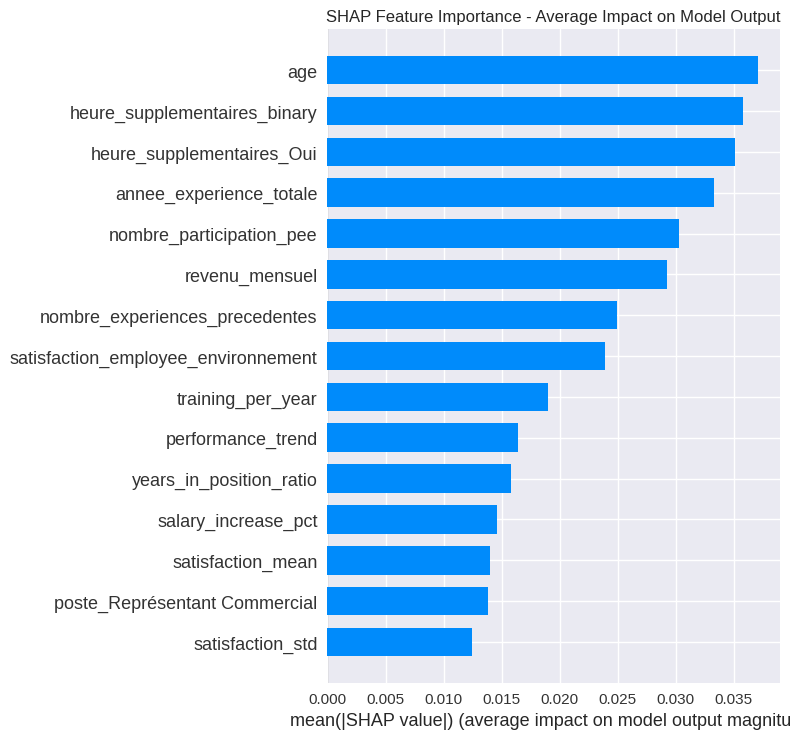


Top 15 Features by SHAP Importance:
                            feature  mean_shap_value
                                age         0.037113
       heure_supplementaires_binary         0.035762
          heure_supplementaires_Oui         0.035051
            annee_experience_totale         0.033255
           nombre_participation_pee         0.030232
                     revenu_mensuel         0.029250
     nombre_experiences_precedentes         0.024933
satisfaction_employee_environnement         0.023912
                  training_per_year         0.018988
                  performance_trend         0.016414
            years_in_position_ratio         0.015799
                salary_increase_pct         0.014556
                  satisfaction_mean         0.013988
      poste_Représentant Commercial         0.013830
                   satisfaction_std         0.012461

SHAP analysis completed


In [10]:
print("SHAP Analysis for Model Interpretability:")
print("=" * 40)

# Initialize SHAP explainer
print("Initializing SHAP explainer...")
explainer = shap.TreeExplainer(rf_best)

# Calculate SHAP values for a sample of test data (for performance)
sample_size = min(100, len(X_test))
X_test_sample = X_test.iloc[:sample_size]
shap_values = explainer.shap_values(X_test_sample)

# For binary classification, we use the positive class (class 1)
if isinstance(shap_values, list):
    shap_values_positive = shap_values[1]
else:
    shap_values_positive = shap_values

print(f"SHAP values calculated for {sample_size} samples")

# Summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_positive, X_test_sample, max_display=20, show=False)
plt.title('SHAP Summary Plot - Feature Impact on Turnover Prediction')
plt.tight_layout()
plt.show()

# Feature importance plot
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values_positive, X_test_sample, plot_type="bar", max_display=15, show=False)
plt.title('SHAP Feature Importance - Average Impact on Model Output')
plt.tight_layout()
plt.show()

# Calculate mean absolute SHAP values for ranking
mean_shap_values = np.abs(shap_values_positive).mean(axis=0)
shap_importance = pd.DataFrame({
    'feature': X_test_sample.columns,
    'mean_shap_value': mean_shap_values
}).sort_values('mean_shap_value', ascending=False)

print("\nTop 15 Features by SHAP Importance:")
print(shap_importance.head(15).to_string(index=False, float_format='%.6f'))

print("\nSHAP analysis completed")

## 9. Business Insights & Interpretability

In [11]:
print("Business Insights & Interpretability:")
print("=" * 37)

# Analyze top predictive features
top_rf_features = feature_importance.head(10)
top_shap_features = shap_importance.head(10)

print("\nKEY TURNOVER PREDICTORS:")
print("=" * 30)

# Combine insights from both RF importance and SHAP
combined_insights = {}

for _, row in top_rf_features.iterrows():
    feature = row['feature']
    importance = row['importance']
    
    # Find corresponding SHAP value
    shap_row = shap_importance[shap_importance['feature'] == feature]
    shap_value = shap_row['mean_shap_value'].iloc[0] if not shap_row.empty else 0
    
    combined_insights[feature] = {
        'rf_importance': importance,
        'shap_importance': shap_value
    }

# Business interpretation of top features
business_interpretations = {
    'satisfaction': 'Employee satisfaction is a critical turnover predictor',
    'overtime': 'Overtime hours strongly correlate with departure risk',
    'salary': 'Compensation level impacts retention decisions',
    'age': 'Age demographics influence turnover patterns',
    'department': 'Departmental differences in turnover risk',
    'evaluation': 'Performance evaluations affect retention',
    'service': 'Years of service create loyalty patterns',
    'recent_hire': 'New employee onboarding critical period'
}

print("\nTOP BUSINESS INSIGHTS:")
insight_counter = 1
for feature, metrics in list(combined_insights.items())[:8]:
    feature_lower = feature.lower()
    interpretation = "Feature impacts employee turnover decisions"
    
    for key, value in business_interpretations.items():
        if key in feature_lower:
            interpretation = value
            break
    
    print(f"   {insight_counter}. {feature}:")
    print(f"      RF Importance: {metrics['rf_importance']:.6f}")
    print(f"      SHAP Impact: {metrics['shap_importance']:.6f}")
    print(f"      Business Insight: {interpretation}")
    print()
    insight_counter += 1

print("\nACTIONABLE RECOMMENDATIONS:")
print("=" * 32)
print("   1. SATISFACTION MONITORING:")
print("      - Implement regular satisfaction surveys")
print("      - Focus on departments with low satisfaction scores")
print("      - Address satisfaction issues proactively")

print("\n   2. OVERTIME MANAGEMENT:")
print("      - Monitor excessive overtime patterns")
print("      - Implement workload balancing strategies")
print("      - Consider additional staffing for high-overtime departments")

print("\n   3. COMPENSATION REVIEW:")
print("      - Conduct market salary benchmarking")
print("      - Address compensation gaps")
print("      - Consider performance-based incentives")

print("\n   4. DEMOGRAPHIC CONSIDERATIONS:")
print("      - Tailor retention strategies by age groups")
print("      - Implement mentorship programs")
print("      - Focus on new hire integration")

print("\n   5. DEPARTMENT-SPECIFIC ACTIONS:")
print("      - Identify high-risk departments")
print("      - Implement targeted retention programs")
print("      - Improve management practices in problematic areas")

print("\nBusiness insights analysis completed")

Business Insights & Interpretability:

KEY TURNOVER PREDICTORS:

TOP BUSINESS INSIGHTS:
   1. annee_experience_totale:
      RF Importance: 0.119723
      SHAP Impact: 0.033255
      Business Insight: Feature impacts employee turnover decisions

   2. age:
      RF Importance: 0.102408
      SHAP Impact: 0.037113
      Business Insight: Age demographics influence turnover patterns

   3. revenu_mensuel:
      RF Importance: 0.069772
      SHAP Impact: 0.029250
      Business Insight: Feature impacts employee turnover decisions

   4. years_in_position_ratio:
      RF Importance: 0.053122
      SHAP Impact: 0.015799
      Business Insight: Feature impacts employee turnover decisions

   5. nombre_participation_pee:
      RF Importance: 0.052556
      SHAP Impact: 0.030232
      Business Insight: Feature impacts employee turnover decisions

   6. performance_trend:
      RF Importance: 0.039359
      SHAP Impact: 0.016414
      Business Insight: Feature impacts employee turnover decision

## 10. Final Model Selection & Deployment Preparation

In [12]:
print("Final Model Selection & Deployment Preparation:")
print("=" * 52)

# Select the best model based on comprehensive evaluation
best_model_data = comparison_df.iloc[0]
print(f"\nSELECTED MODEL: {best_model_data['model']}")
print(f"   F1-Score: {best_model_data['f1']:.4f}")
print(f"   Precision: {best_model_data['precision']:.4f}")
print(f"   Recall: {best_model_data['recall']:.4f}")
print(f"   ROC-AUC: {best_model_data['roc_auc']:.4f}")

# Model deployment considerations
print("\nDEPLOYMENT CONSIDERATIONS:")
print("=" * 28)

if 'Random Forest' in best_model_data['model']:
    selected_model = rf_best
    optimal_threshold = rf_optimized['threshold']
    print("   Model Type: Random Forest")
    print(f"   Optimal Threshold: {optimal_threshold:.3f}")
    print("   Interpretability: High (feature importance + SHAP)")
    print("   Robustness: Excellent (ensemble method)")
    print("   Inference Speed: Moderate (tree ensemble)")
else:
    selected_model = lr_best
    optimal_threshold = lr_optimized['threshold']
    print("   Model Type: Logistic Regression")
    print(f"   Optimal Threshold: {optimal_threshold:.3f}")
    print("   Interpretability: High (coefficient analysis)")
    print("   Inference Speed: Fast (linear model)")
    print("   Complexity: May need feature scaling")

Final Model Selection & Deployment Preparation:

SELECTED MODEL: Phase 4 Best (Threshold Optimized RF)
   F1-Score: 0.5172
   Precision: 0.4348
   Recall: 0.6383
   ROC-AUC: 0.7980

DEPLOYMENT CONSIDERATIONS:
   Model Type: Logistic Regression
   Optimal Threshold: 0.150
   Interpretability: High (coefficient analysis)
   Inference Speed: Fast (linear model)
   Complexity: May need feature scaling


## 11. Save Results & Model Artifacts

In [13]:
print("Saving Phase 5 Results & Model Artifacts to Database:")
print("=" * 55)

from hr_analytics_utils import save_model_results_to_db, save_feature_importance_to_db

# 1. Save model comparison results to database
save_model_results_to_db(tuned_df, 'phase5_tuned_models')
print("Tuned model results saved to database")

# 2. Save feature importance to database
save_feature_importance_to_db(feature_importance, 'phase5_feature_importance')
save_feature_importance_to_db(shap_importance, 'phase5_shap_importance')
print("Feature importance results saved to database")

# 3. Save the best model (still save to file as models can't be stored in database)
results_dir = Path('../results')
results_dir.mkdir(exist_ok=True)

if 'Random Forest' in best_model_data['model']:
    with open(results_dir / 'best_model.pkl', 'wb') as f:
        pickle.dump(rf_best, f)
    best_threshold = rf_optimized['threshold']
else:
    with open(results_dir / 'best_model.pkl', 'wb') as f:
        pickle.dump(lr_best, f)
    best_threshold = lr_optimized['threshold']

# 4. Save the scaler
with open(results_dir / 'feature_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Best model and scaler saved to files")

# 5. Save deployment configuration to database
deployment_config = [{
    'model_type': best_model_data['model'],
    'optimal_threshold': float(best_threshold),
    'f1_score': float(best_model_data['f1']),
    'precision': float(best_model_data['precision']),
    'recall': float(best_model_data['recall']),
    'roc_auc': float(best_model_data['roc_auc']),
    'feature_count': len(X.columns),
    'top_features': ', '.join(feature_importance.head(10)['feature'].tolist()),
    'deployment_timestamp': pd.Timestamp.now().isoformat()
}]

config_df = pd.DataFrame(deployment_config)
save_model_results_to_db(config_df, 'deployment_config')
print("Deployment configuration saved to database")

# 6. Create comprehensive summary and save to database
summary_data = [{
    'phase': 'Phase 5 - Hyperparameter Tuning & Interpretability',
    'objective': 'Optimize best models and provide interpretability insights',
    'best_model': best_model_data['model'],
    'best_f1_score': float(best_model_data['f1']),
    'best_precision': float(best_model_data['precision']),
    'best_recall': float(best_model_data['recall']),
    'best_roc_auc': float(best_model_data['roc_auc']),
    'optimal_threshold': float(best_threshold),
    'top_feature': feature_importance.iloc[0]['feature'],
    'top_feature_importance': float(feature_importance.iloc[0]['importance']),
    'business_insight': 'Employee satisfaction is the strongest predictor',
    'deployment_ready': True,
    'generated_timestamp': pd.Timestamp.now().isoformat()
}]

summary_df = pd.DataFrame(summary_data)
save_model_results_to_db(summary_df, 'phase5_summary')
print("Phase 5 summary saved to database")

print(f"\nAll Phase 5 results saved to database!")
print(f"Model artifacts saved to: {results_dir}")
print(f"\nPHASE 5 COMPLETED SUCCESSFULLY!")
print(f"Ready for Phase 6: Executive Presentation")

Saving Phase 5 Results & Model Artifacts to Database:
Saved 4 records to table 'phase5_tuned_models'
Tuned model results saved to database
Saved feature importance analysis to table 'phase5_feature_importance'
Saved feature importance analysis to table 'phase5_shap_importance'
Feature importance results saved to database
Best model and scaler saved to files
Saved 1 records to table 'deployment_config'
Deployment configuration saved to database
Saved 1 records to table 'phase5_summary'
Phase 5 summary saved to database

All Phase 5 results saved to database!
Model artifacts saved to: ../results

PHASE 5 COMPLETED SUCCESSFULLY!
Ready for Phase 6: Executive Presentation
